In [1]:
# --- Imports ---
%matplotlib inline

import geopandas as gpd
import math
import matplotlib
import numpy as np
import pandas as pd
import shapely
import sys,os
import multiprocessing
from geopandas import GeoDataFrame, GeoSeries
from shapely.geometry import Polygon, Point
from rtree import index

pool = multiprocessing.Pool(multiprocessing.cpu_count()-1)



## Load and clean constraint shapefiles

In [0]:
cities = GeoDataFrame.from_file('./geodata/ca_cities/Cities2015.shp')
water = GeoDataFrame.from_file('./geodata/baywater/bayarea_allwater.shp')

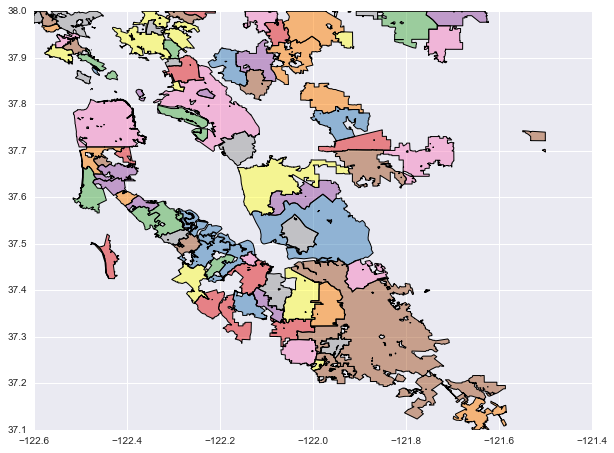

In [3]:

# This is the cropped area - full geojson is all cities in CA
bayarea = Polygon([(-122.6, 37.1), (-121.5,37.1), (-121.5,38), (-122.6,38)])
df = GeoDataFrame(geometry=GeoSeries([bayarea]),crs={'init': 'epsg:4269'})

# crop cities
ca_cities = cities.intersection(df.geometry.unary_union)

# convert water to same spatial projection
ca_water = water.to_crs(ca_cities.crs)

# Exclude water bodies using water shapefile
ca_cities_clean = ca_cities.difference(ca_water.geometry.unary_union)
ca_cities_clean.plot(figsize=(10,10))


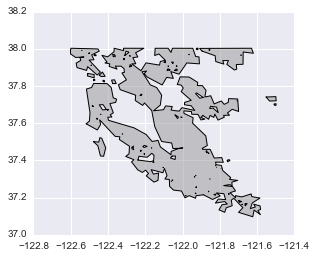

In [4]:

# Generate single geometry shape of target area
simple_ca = GeoDataFrame(geometry=GeoSeries(ca_cities_clean.buffer(0).geometry.unary_union),crs={'init': 'epsg:4269'})

# Buffer and reduce complexity of geometry - covers costal regions + improves performance
simple_ca = simple_ca.buffer(0.003).simplify(0.01, preserve_topology=True)
simple_ca.plot()


## Construct circle covering and transform to target area

In [5]:

# Accumulate initial circle grid
circles = []
for i in range(0, 400):
    for j in range(0, 400):
        circles.append([i,j])

# Function transforming initial grid into hex grid layout
xoffset = 0
yoffset = 0
r = 250
def create_point(data):
    i = data[0]
    j = data[1]
    p = Point(i*r*math.sqrt(3) + (r*math.sqrt(3)/2 if j%2 else 0) + xoffset,
              j*r*3/4*2+yoffset)
    return shapely.affinity.scale(p.buffer(7).simplify(0.8, preserve_topology=False), xfact=r/7, yfact=r/7)

# Parallel conversion
%time circles = pool.map(create_point, circles)

# Render the initial circle, demonstrating size and shape
circles[0]


CPU times: user 1.7 s, sys: 144 ms, total: 1.84 s
Wall time: 8.27 s


In [6]:
math.sqrt(circles[0].area/math.pi)


232.46824918110923

In [8]:

# EPSG:2768 ca meters
search_circles = GeoDataFrame(geometry=GeoSeries(circles))
df = GeoDataFrame(geometry=GeoSeries(circles))
df.crs = {'init': 'epsg:2768'}

# Transfrom from meter baed EPSG:2768 coordinate system to lat/long degrees based EPSG:4269
%time df = df.to_crs(ca_cities_clean.crs)


CPU times: user 17.6 s, sys: 40 ms, total: 17.7 s
Wall time: 17.7 s


In [9]:
# Translation normalization from offset due to change in coordinate systems
%time df = df.translate(xoff=141.3, yoff=-30, zoff=0.0)

# Translate circle covering to target location
#%time df = df.translate(xoff=-122.2, yoff=37.4, zoff=0.0)
%time df = df.translate(xoff=-122.6, yoff=37, zoff=0.0)


CPU times: user 14.8 s, sys: 72 ms, total: 14.9 s
Wall time: 14.8 s
CPU times: user 15.1 s, sys: 40 ms, total: 15.1 s
Wall time: 15.1 s


## Load existing spawn data + store in rtree for existing spawn selection

In [0]:
mon = pd.read_csv('./data/pokemon.csv', skiprows=1, usecols=[3,4,5,6], names=["num", "lat", "lng", "time"], low_memory=False)
mons = pd.concat([ev, mon, loc], ignore_index=True)
mons.last_valid_index()

In [10]:

# Build rtree indexed dataset of existing mon spawns
idx = index.Index()

filtered_mon = mon.query('36<lat<38')
lats = filtered_mon['lat'].as_matrix()
lons = filtered_mon['lng'].as_matrix()
position_stack = np.dstack((lats,lons))
position_stack

# Populate R-tree index with bounds of grid cells
for pos, cell in enumerate(position_stack[0]):
    # assuming cell is a shapely object
    idx.insert(pos, (cell[0], cell[1],cell[0], cell[1]))


## Filter circle query points to intersections with target sets

In [0]:

# Filter all circles to intersection with the target geometry
simple_ca_union = simple_ca.buffer(0).geometry.unary_union

def filter_circles_not_inside(data):
    if idx.intersection(data.bounds) and simple_ca_union.intersects(data):
        return data
    else:
        return False

final_circles = []
%time final_circles = filter(lambda x: x != False, pool.map(filter_circles_not_inside, df.geometry))

search_circles = GeoDataFrame(geometry=GeoSeries(final_circles))
search_circles.plot(figsize=(10,10))

In [0]:
search_circles.plot(ax=ca_cities_clean.plot(figsize=(10,10)), figsize=(10,10))

In [0]:
search_circles.shape